In [1]:
%config Completer.use_jedi = False

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.transform_utils import generate_2dmotion_field
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
from src.echonet_dataset import EchoNetDynamicDataset
from src.clasfv_losses import deformation_motion_loss, motion_seg_loss, DiceLoss, categorical_dice
from src.train_test import train, test

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

### Load the indices of the subset data used for training and validating

Subset out our Train and Validation Dataset. We exclude the EchoNet videos with no clinically denoted systolic clip or ED-ES duration > 30 frames.

In [2]:
with open("fold_indexes/stanford_train_sampled_indices", "rb") as infile:
    train_mask = pickle.load(infile)
infile.close()

with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

### Set up the training and validating dataset
work initialization function is required for generating **random** 32-frame video clip in each training epoch  
Fail to initialize the worker will cause the random 32-frame window to be the **same** for a video during every epoch.

In [3]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

### Load in the dataset

In [4]:
train_dataset = EchoNetDynamicDataset(split='train', subset_indices=train_mask, period=1)
valid_dataset = EchoNetDynamicDataset(split='val', subset_indices=valid_mask, period=1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                              num_workers=num_workers, 
                              shuffle=True, pin_memory=("cuda"), 
                              worker_init_fn=worker_init_fn,
                              drop_last=True)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, 
                              num_workers=num_workers,
                              shuffle=False, pin_memory=("cuda"),
                              worker_init_fn=worker_init_fn_valid
                             )

100%|██████████| 16/16 [00:01<00:00, 14.53it/s]


### Instantiate the CLAS-FV Model

In [5]:
model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")

print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

lr_T = 1e-4 
optimizer = optim.Adam(model.parameters(), lr=lr_T)

R2+1D MotionNet has 31575731 parameters.


### Train and Test the CLAS-FV model for eight epochs

In [6]:
Tensor = torch.cuda.FloatTensor

model_save_path = "save_models/R2plus1DMotionSegNet_model.pth"

train_loss_list = []
valid_loss_list = []

n_epoch = 10
min_loss = 1e5
for epoch in range(1, n_epoch + 1):
    print("-" * 32 + 'Epoch {}'.format(epoch) + "-" * 32)
    start = time.time()
    train_loss = train(epoch, train_loader=train_dataloader, model=model, optimizer=optimizer)
    train_loss_list.append(np.mean(train_loss))
    end = time.time()
    print("training took {:.8f} seconds".format(end-start))
    valid_loss = test(epoch, test_loader=valid_dataloader, model=model, optimizer=optimizer)
    valid_loss_list.append(np.mean(valid_loss))
    
    if (np.mean(valid_loss) < min_loss) and (epoch > 0):
        min_loss = np.mean(valid_loss)
        torch.save({"model": model.state_dict(), "optimizer": optimizer.state_dict()}, model_save_path)
        
    if epoch == 3:
        lr_T = 1e-5
        optimizer = optim.Adam(model.parameters(), lr=lr_T)

--------------------------------Epoch 1--------------------------------

Train Epoch: 1 [1120/7332 (15%)]	Loss: 0.959822
ED LV: 0.792
ES LV: 0.686
On a particular batch:
Deform loss:  tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)
Segmentation loss:  tensor(0.3069, device='cuda:0', grad_fn=<DivBackward0>)
Seg Motion loss:  tensor(0.3064, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0187, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 1 [2240/7332 (31%)]	Loss: 0.746199
ED LV: 0.848
ES LV: 0.771
On a particular batch:
Deform loss:  tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)
Segmentation loss:  tensor(0.1975, device='cuda:0', grad_fn=<DivBackward0>)
Seg Motion loss:  tensor(0.1910, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0216, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 1 [3360/7332 (46%)]	Loss: 0.610871
ED LV: 0.872
ES LV: 0.810
On a particular batch:
Deform loss:  tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)
Segmentation

### Load the pretrained models

In [7]:
model_save_path = "save_models/R2plus1DMotionSegNet_model_tmp.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


# -----Visualization-----

### Get some echo video clips from Validation Dataset

In [8]:
i = 0
threshold = 34
# threshold = np.random.randint(0, len(valid_dataloader))

np.random.seed()
for data in valid_dataloader:
    i += 1
    data = data
    if i > threshold:
        break

In [9]:
video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = data

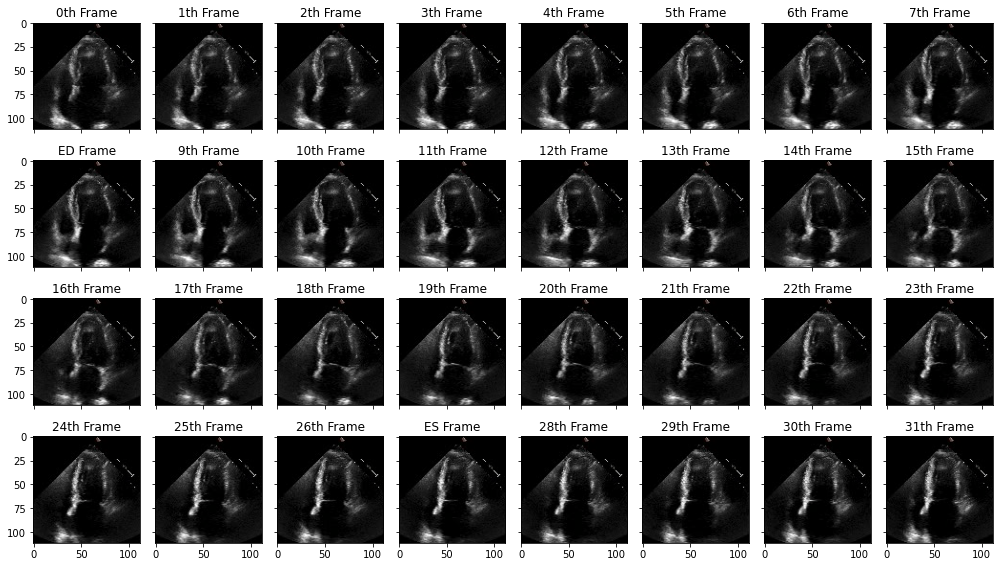

In [10]:
batch_inside_index = 0

fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j == ed_clip_index[batch_inside_index]:
            ax[i][j].set_title("ED Frame")
        elif i * 8 + j == es_clip_index[batch_inside_index]:
            ax[i][j].set_title("ES Frame")
        else:
            ax[i][j].set_title("{:d}th Frame".format(i * 8 + j))
        ax[i][j].imshow(video[batch_inside_index, :, i * 8 + j].cpu().detach().numpy().transpose([1, 2, 0]))
        
plt.tight_layout()
plt.show()

In [11]:
%%capture

from src.utils.echo_utils import makeVideo

vid_animation = makeVideo(video.cpu().detach().numpy()[batch_inside_index].transpose([1, 2, 3, 0]))

In [12]:
vid_animation

In [13]:
segmentation_output, motion_output = model(torch.Tensor(video))

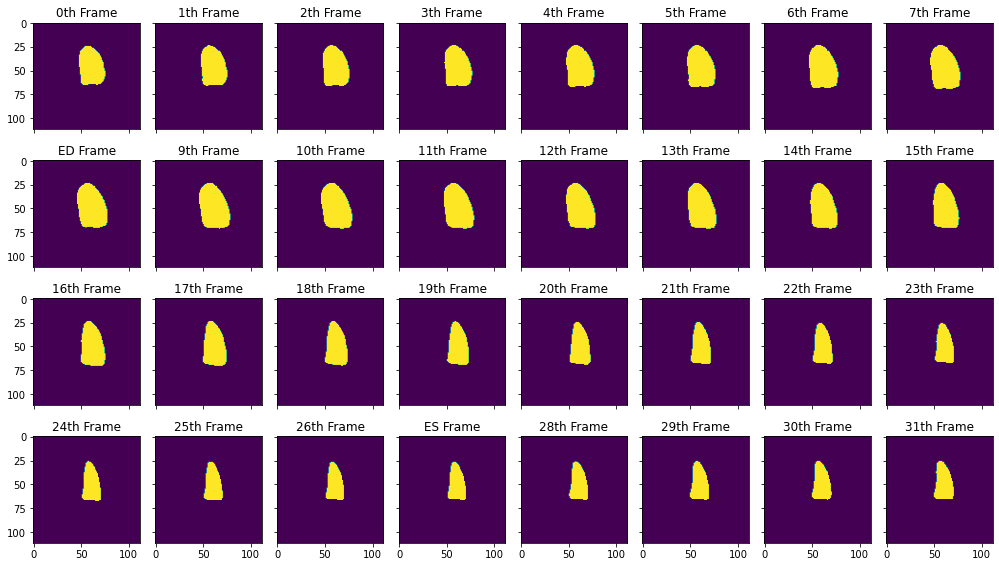

In [17]:
segmentation = torch.argmax(segmentation_output, 1).cpu().detach().numpy()[batch_inside_index]
fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j == ed_clip_index[batch_inside_index]:
            ax[i][j].set_title("ED Frame")
        elif i * 8 + j == es_clip_index[batch_inside_index]:
            ax[i][j].set_title("ES Frame")
        else:
            ax[i][j].set_title("{:d}th Frame".format(i * 8 + j))
        ax[i][j].imshow(segmentation[i * 8 + j])
        
plt.tight_layout()
plt.show()

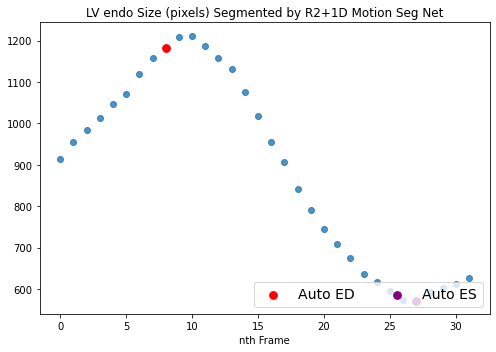

In [18]:
plt.figure(figsize=(7, 5))
lv_sizes = np.sum(segmentation, axis=(1, 2))
plt.scatter(np.arange(32), lv_sizes, alpha=0.8)

plt.scatter(ed_clip_index[batch_inside_index], lv_sizes[ed_clip_index[batch_inside_index]],
            color="red", s=60, label="Auto ED")

plt.scatter(es_clip_index[batch_inside_index], lv_sizes[es_clip_index[batch_inside_index]],
            color="purple", s=60, label="Auto ES")

plt.title("LV endo Size (pixels) Segmented by R2+1D Motion Seg Net")
plt.xlabel("nth Frame")

plt.legend(loc="lower right", fontsize=14, ncol=2)
plt.tight_layout()
plt.show()

In [20]:
from src.visualization_utils import get_deformed_label_forback

label_image = {"label_ED": np.expand_dims(np.expand_dims(ed_label[batch_inside_index], 0), 0),
               "label_ES": np.expand_dims(np.expand_dims(es_label[batch_inside_index], 0), 0)}

grid_mode = "bilinear"

flow_source_backward = torch.Tensor(label_image["label_ES"])
es_backwards = [label_image["label_ES"]]
for frame_index in range(es_clip_index[batch_inside_index], ed_clip_index[batch_inside_index], -1):
    motion_field = generate_2dmotion_field(flow_source_backward, motion_output[[batch_inside_index], 2:, frame_index,...])
    new_label = F.grid_sample(flow_source_backward.cuda(), motion_field, align_corners=False, mode=grid_mode, padding_mode='border')
    flow_source_backward = new_label
    if frame_index == ed_clip_index[batch_inside_index] + 1:
        backward_deformed_ed = new_label 
    else:
        es_backwards.append(new_label)
    
flow_source_backward = torch.Tensor(label_image["label_ED"])
ed_backwards = [label_image["label_ED"]]
for frame_index in range(ed_clip_index[batch_inside_index], 0, -1):
    motion_field = generate_2dmotion_field(flow_source_backward, motion_output[[batch_inside_index], 2:, frame_index,...])
    new_label = F.grid_sample(flow_source_backward.cuda(), motion_field, align_corners=False, mode=grid_mode, padding_mode='border')
    flow_source_backward = new_label
    ed_backwards.append(new_label)

flow_source_forward = torch.Tensor(label_image["label_ED"])
ed_forwards = [label_image["label_ED"]]
for frame_index in range(ed_clip_index[batch_inside_index], es_clip_index[batch_inside_index]):
    motion_field = generate_2dmotion_field(flow_source_forward, motion_output[[batch_inside_index], :2, frame_index,...])
    new_label = F.grid_sample(flow_source_forward.cuda(), motion_field, align_corners=False, mode=grid_mode, padding_mode='border')
    flow_source_forward = new_label
    if frame_index == es_clip_index[batch_inside_index] - 1:
        forward_deformed_es = new_label
    else:
        ed_forwards.append(new_label)
    
flow_source_forward = torch.Tensor(label_image["label_ES"])
es_forwards = [label_image["label_ES"]]
for frame_index in range(es_clip_index[batch_inside_index], 31):
    motion_field = generate_2dmotion_field(flow_source_forward, motion_output[[batch_inside_index], :2, frame_index,...])
    new_label = F.grid_sample(flow_source_forward.cuda(), motion_field, align_corners=False, mode=grid_mode, padding_mode='border')
    flow_source_forward = new_label
    es_forwards.append(new_label)

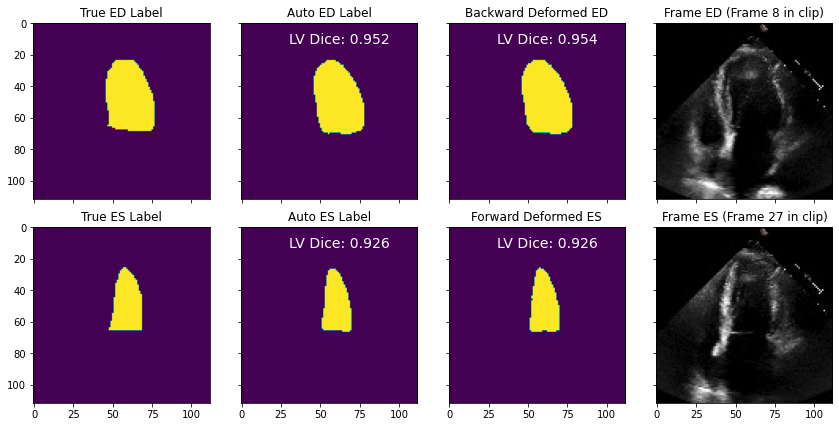

In [20]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
ax[0][0].imshow(ed_label[batch_inside_index].numpy())
ax[0][0].set_title("True ED Label")

ax[0][1].imshow(segmentation[ed_clip_index[batch_inside_index]])
ax[0][1].set_title("Auto ED Label")
ax[0][1].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(ed_label[batch_inside_index].numpy(), 
                                       segmentation[ed_clip_index[batch_inside_index]], 1)),
             color="white", fontsize=14)

backward_deformed_ed[backward_deformed_ed > 0.05] = 1
ax[0][2].set_title("Backward Deformed ED")
ax[0][2].imshow(backward_deformed_ed[0, 0].cpu().detach().numpy())
ax[0][2].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(ed_label[batch_inside_index].numpy(), 
                                       backward_deformed_ed[0, 0].cpu().detach().numpy(), 1)),
              color="white", fontsize=14)

ax[0][3].imshow(video[batch_inside_index, :, ed_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]))
ax[0][3].set_title("Frame ED (Frame {:d} in clip)".format(ed_clip_index[batch_inside_index]))

ax[1][0].imshow(es_label[batch_inside_index].numpy())
ax[1][0].set_title("True ES Label")

ax[1][1].imshow(segmentation[es_clip_index[batch_inside_index]])
ax[1][1].set_title("Auto ES Label")
ax[1][1].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(es_label[batch_inside_index].numpy(), 
                                       segmentation[es_clip_index[batch_inside_index]], 1)),
             color="white", fontsize=14)

forward_deformed_es[forward_deformed_es > 0.05] = 1
ax[1][2].set_title("Forward Deformed ES")
ax[1][2].imshow(forward_deformed_es[0, 0].cpu().detach().numpy())
ax[1][2].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(es_label[batch_inside_index].numpy(), 
                                       forward_deformed_es[0, 0].cpu().detach().numpy(), 1)),
              color="white", fontsize=14)

ax[1][3].imshow(video[batch_inside_index, :,es_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]))
ax[1][3].set_title("Frame ES (Frame {:d} in clip)".format(es_clip_index[batch_inside_index]))

plt.tight_layout()
plt.show()

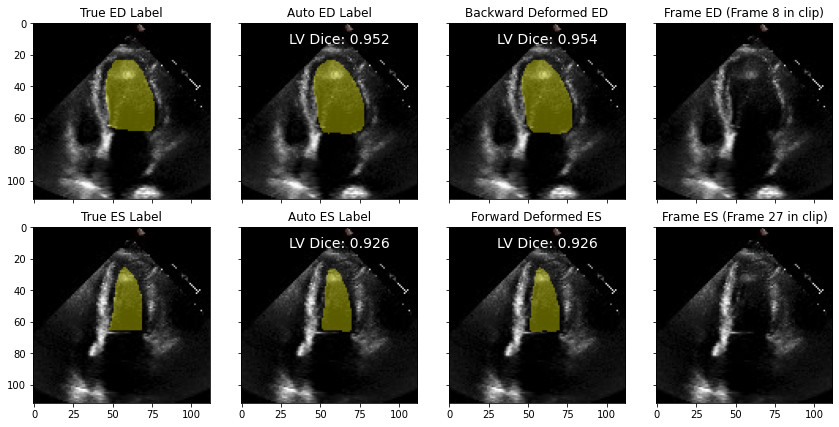

In [40]:
from src.visualization_utils import echonet_overlay

overlay_true_ed_frame = echonet_overlay(video[batch_inside_index, :, ed_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]), 
                                        ed_label[batch_inside_index].numpy(), 
                                        vis=False, alpha=1.2)

overlay_auto_ed_frame = echonet_overlay(video[batch_inside_index, :, ed_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]), 
                                        segmentation[ed_clip_index[batch_inside_index]], 
                                        vis=False, alpha=1.2)

overlay_defm_ed_frame = echonet_overlay(video[batch_inside_index, :, ed_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]), 
                                        backward_deformed_ed[0, 0].cpu().detach().numpy(), 
                                        vis=False, alpha=1.2)

fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
ax[0][0].imshow(overlay_true_ed_frame)
ax[0][0].set_title("True ED Label")

ax[0][1].imshow(overlay_auto_ed_frame)
ax[0][1].set_title("Auto ED Label")
ax[0][1].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(ed_label[batch_inside_index].numpy(), 
                                       segmentation[ed_clip_index[batch_inside_index]], 1)),
             color="white", fontsize=14)

backward_deformed_ed[backward_deformed_ed > 0.05] = 1
ax[0][2].set_title("Backward Deformed ED")
ax[0][2].imshow(overlay_defm_ed_frame)
ax[0][2].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(ed_label[batch_inside_index].numpy(), 
                                       backward_deformed_ed[0, 0].cpu().detach().numpy(), 1)),
              color="white", fontsize=14)

ax[0][3].imshow(video[batch_inside_index, :, ed_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]))
ax[0][3].set_title("Frame ED (Frame {:d} in clip)".format(ed_clip_index[batch_inside_index]))

overlay_true_es_frame = echonet_overlay(video[batch_inside_index, :, es_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]), 
                                        es_label[batch_inside_index].numpy(), 
                                        vis=False, alpha=1.2)

overlay_auto_es_frame = echonet_overlay(video[batch_inside_index, :, es_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]), 
                                        segmentation[es_clip_index[batch_inside_index]], 
                                        vis=False, alpha=1.2)

overlay_defm_es_frame = echonet_overlay(video[batch_inside_index, :, es_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]), 
                                        forward_deformed_es[0, 0].cpu().detach().numpy(), 
                                        vis=False, alpha=1.2)

ax[1][0].imshow(overlay_true_es_frame)
ax[1][0].set_title("True ES Label")

ax[1][1].imshow(overlay_auto_es_frame)
ax[1][1].set_title("Auto ES Label")
ax[1][1].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(es_label[batch_inside_index].numpy(), 
                                       segmentation[es_clip_index[batch_inside_index]], 1)),
             color="white", fontsize=14)

forward_deformed_es[forward_deformed_es > 0.05] = 1
ax[1][2].set_title("Forward Deformed ES")
ax[1][2].imshow(overlay_defm_es_frame)
ax[1][2].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(es_label[batch_inside_index].numpy(), 
                                       forward_deformed_es[0, 0].cpu().detach().numpy(), 1)),
              color="white", fontsize=14)

ax[1][3].imshow(video[batch_inside_index, :,es_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]))
ax[1][3].set_title("Frame ES (Frame {:d} in clip)".format(es_clip_index[batch_inside_index]))

plt.tight_layout()
plt.show()

Forward Deformation


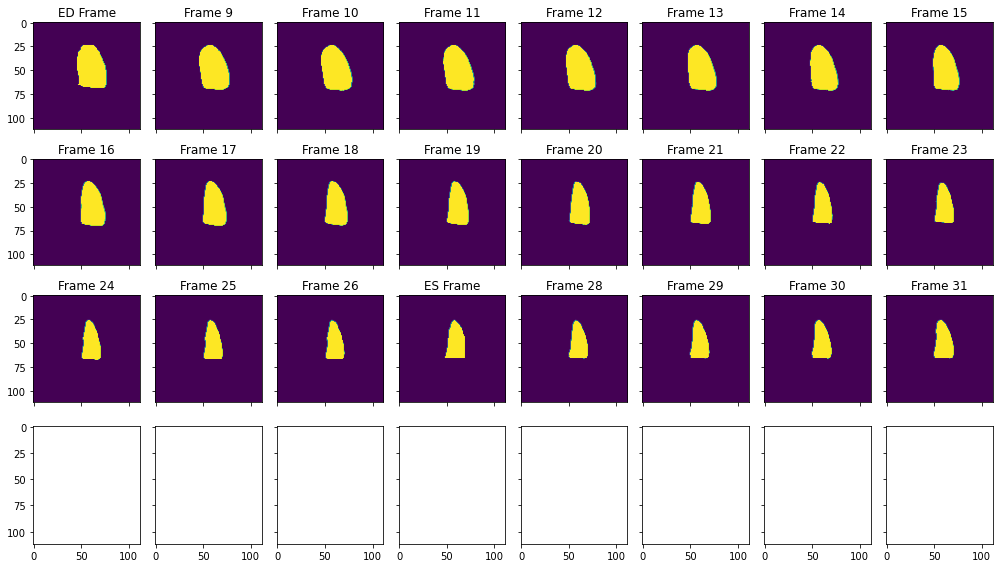

In [45]:
print("Forward Deformation")

forward_deformation = ed_forwards + es_forwards 
fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j >= len(forward_deformation):
            continue
        if i + j == 0:
            ax[i][j].set_title("ED Frame")
        elif i * 8 + j == len(ed_forwards):
            ax[i][j].set_title("ES Frame")
        else:
            ax[i][j].set_title("Frame {:d}".format(i * 8 + j + ed_clip_index[batch_inside_index]))
        try:
            ax[i][j].imshow(forward_deformation[i * 8 + j][0, 0].cpu().detach().numpy())
        except:
            ax[i][j].imshow(forward_deformation[i * 8 + j][0, 0])
        
plt.tight_layout()
plt.show()

Backward Deformation


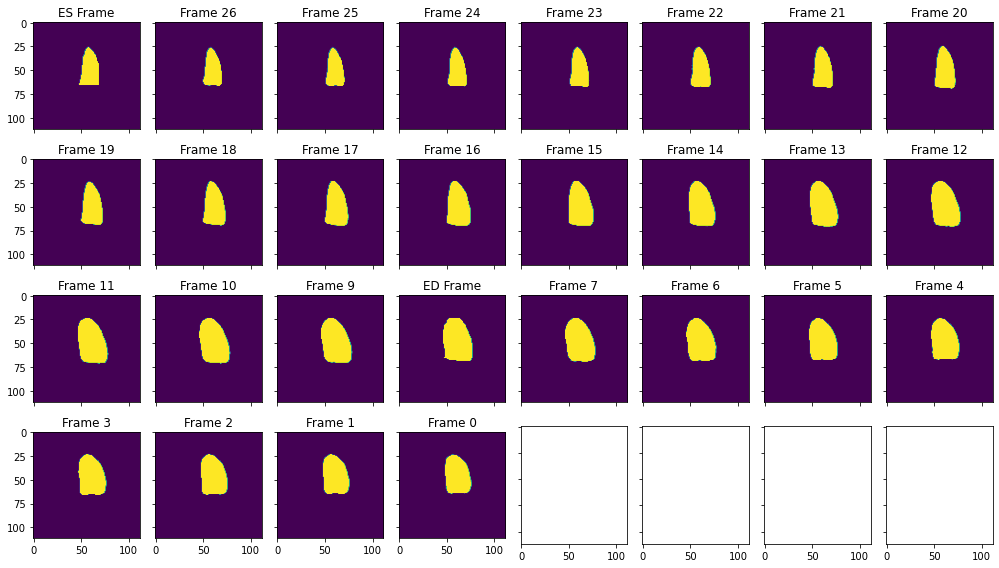

In [28]:
print("Backward Deformation")

backward_deformation = es_backwards + ed_backwards 
fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j >= len(backward_deformation):
            continue
        if i + j == 0:
            ax[i][j].set_title("ES Frame")
        elif i * 8 + j == len(es_backwards):
            ax[i][j].set_title("ED Frame")
        else:
            ax[i][j].set_title("Frame {:d}".format(es_clip_index[batch_inside_index] - i * 8 - j))
        try:
            ax[i][j].imshow(backward_deformation[i * 8 + j][0, 0].cpu().detach().numpy())
        except:
            ax[i][j].imshow(backward_deformation[i * 8 + j][0, 0])
        
plt.tight_layout()
plt.show()